In [1]:
import requests
import json
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import plot_side_by_side

In [2]:
API_URL = "http://nova.astrometry.net/api"


def get_session_key():
    with open("config.json") as config_file:
        config = json.load(config_file)
    apikey = config["apikey"]
    request = requests.post(
        f"{API_URL}/login",
        data={"request-json": json.dumps({"apikey": apikey})},
    ).json()
    return request["session"]


def get_submission_status(subid, poll_interval=5, max_attempts=5):
    submission_url = f"{API_URL}/submissions/{subid}"

    for attempt in range(1 + max_attempts):
        response = requests.get(submission_url)
        if response.status_code == 200:
            submission_status = response.json()
            if submission_status.get("job_calibrations"):
                print("Image Solved!")
                return submission_status
            else:
                print(f"Attempt {attempt}/{max_attempts}: Waiting for image solving...")
        else:
            print("Error getting submission status. Status code:", response.status_code)
            print(response.text)
            return None

        time.sleep(poll_interval)

    print(f"Max attempts reached. Submission processing might still be ongoing.")
    return None


def submit_image(session_key, file_path):
    """
    Submit an image file to the Astrometry API for plate-solving.
    Reference:
        Astrometry.net API Documentation: https://astrometry.net/doc/net/api.html
    """
    submission_url = f"{API_URL}/upload"
    files = {
        "request-json": (
            None,
            json.dumps(
                {
                    "publicly_visible": "y",
                    "allow_modifications": "d",
                    "session": session_key,
                    "allow_commercial_use": "d",
                }
            ),
            "text/plain",
        ),
        "file": ("image.jpg", open(file_path, "rb"), "application/octet-stream"),
    }

    response = requests.post(submission_url, files=files)

    if response.status_code == 200:
        print("File submitted successfully!")
        return response.json()
    else:
        print("Error submitting file. Status code:", response.status_code)
        print(response.text)
        return None


def get_job_status(jobid):
    submission_url = f"{API_URL}/jobs/{jobid}"
    response = requests.get(submission_url)
    if response.status_code == 200:
        print("Job status retrieved successfully!")
        return response.json()
    else:
        print("Error retrieving job status. Status code:", response.status_code)
        print(response.text)
        return None


def get_annotations(jobid):
    submission_url = f"{API_URL}/jobs/{jobid}/annotations/"
    response = requests.get(submission_url)
    if response.status_code == 200:
        print("Coordnates retrieved successfully!")
        return response.json()
    else:
        print("Error retrieving coordinates. Status code:", response.status_code)
        print(response.text)
        return None


def draw_crosshair(
    image,
    center,
    legend_text,
    size=35,
    gap_size=15,
    thickness=2,
    color=(0, 255, 0),
    font_scale=1.5,
    font_thickness=2,
    text_distance=30,
):
    marked_image = image.copy()
    x, y = center

    # Draw horizontal lines with a gap in the middle
    cv2.line(marked_image, (x - size, y), (x - gap_size, y), color, thickness)
    cv2.line(marked_image, (x + gap_size, y), (x + size, y), color, thickness)

    # Draw vertical lines with a gap in the middle
    cv2.line(marked_image, (x, y - size), (x, y - gap_size), color, thickness)
    cv2.line(marked_image, (x, y + gap_size), (x, y + size), color, thickness)

    # Add text/legend next to the crosshair
    angle_radians = np.radians(45)
    text_position_x = int(x + text_distance * np.cos(angle_radians))
    text_position_y = int(y - text_distance * np.cos(angle_radians))
    text_position = (text_position_x, text_position_y)
    cv2.putText(
        marked_image,
        legend_text,
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        color,
        font_thickness,
    )

    return marked_image


def draw_circle(
    image,
    center,
    radius,
    legend_text,
    color=(0, 255, 0),
    thickness=2,
    font_scale=1.5,
    font_thickness=2,
):
    marked_image = image.copy()
    x, y = center

    cv2.circle(marked_image, (x, y), radius, color, thickness)

    # Draw a line from the edge of the circle
    line_length = radius // 3
    line_start = (x + radius, y)
    angle_radians = np.radians(45)
    line_end_x = int(x + radius + line_length * np.cos(angle_radians))
    line_end_y = int(y - line_length * np.cos(angle_radians))
    line_end = (line_end_x, line_end_y)
    cv2.line(marked_image, line_start, line_end, color, thickness)

    # Add text/legend next to the circle
    text_position = (line_end[0] + 10, line_end[1])
    cv2.putText(
        marked_image,
        legend_text,
        text_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        color,
        font_thickness,
    )

    return marked_image


def annotate_image(annotations, image_path):
    image = cv2.imread(image_path)

    for annotation in annotations:
        radius = int(annotation["radius"])
        x, y = int(annotation["pixelx"]), int(annotation["pixely"])
        name = annotation["names"][0]
        if radius == 0:
            image = draw_crosshair(image, (x, y), legend_text=name)
        else:
            image = draw_circle(image, (x, y), radius=radius, legend_text=name)

    return image

File submitted successfully!
Attempt 0/5: Waiting for image solving...
Attempt 1/5: Waiting for image solving...
Image Solved!
Job status retrieved successfully!
Job succeeded!
Coordnates retrieved successfully!


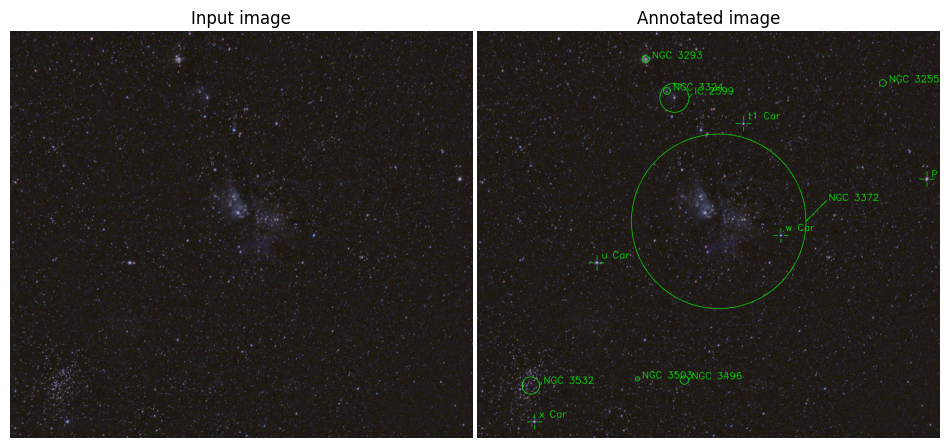

In [3]:
image_path = "carina_nebula_jpeg2_cropped.jpg"
input_image = cv2.imread(image_path)
output_path = image_path.split(".")[0] + "_annotated.jpg"

session_key = get_session_key()
response = submit_image(session_key, image_path)
subid = response["subid"]
submission_status = get_submission_status(subid)
jobid = submission_status["jobs"][0]
job_status = get_job_status(jobid)
if job_status["status"] == "success":
    print("Job succeeded!")
    annotations = get_annotations(jobid)["annotations"]
    annotated_image = annotate_image(annotations, image_path)
    cv2.imwrite(output_path, annotated_image)
    plot_side_by_side([input_image, annotated_image], ["Input image", "Annotated image"], figsize=(12,6))
else:
    print("Job failed!")